<h1>Ejemplos DeepSets</h1>

<h2>Ejemplos de suma de números</h2>

<h3>Creamos conjuntos de números aleatorios entre 0 y 1. Cada uno de ellos tendrá 10 elementos y tendrán como respuesta la suma de sus elementos. </h3>

In [70]:
# Datos de ejemplo (conjunto de 10 elementos con 1 valor cada uno)
num_sets = 1000  # Número de conjuntos
set_size = 10  # Número de elementos por conjunto
input_dim = set_size  # Cada conjunto tiene 10 elementos
output_dim = 1  # Predicción de un único valor para el conjunto

# Datos de entrada (conjuntos de números aleatorios)
X_train = np.random.rand(num_sets, set_size)  # Agregamos la tercera dimensión para las características por elemento

# Etiquetas (suma de los elementos del conjunto)
y_train = np.sum(X_train, axis=1)  # Sumar los valores de cada conjunto

<h3>Creamos la función para la red neuronal</h3>

In [71]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Función para crear el modelo Deep Set
def create_deep_set_model(input_dim, output_dim):
    # Entrada: un conjunto de datos de tamaño arbitrario (número de elementos en el conjunto)
    inputs = layers.Input(shape=(input_dim, 1))  # Cada conjunto tiene 'input_dim' elementos y 1 característica por cada uno.

    # Usamos 'Dense' para conectar completamente las capas
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)

    # Operación simétrica: agregación de los elementos del conjunto
    x = layers.GlobalAveragePooling1D()(x)  # Promediamos las salidas de todos los elementos

    # Capa final para la predicción
    outputs = layers.Dense(output_dim, activation='linear')(x)

    # Modelo
    model = models.Model(inputs, outputs)
    return model

<h3>Entrenamos y ajustamos</h3>

In [81]:

# Crear el modelo Deep Set
model = create_deep_set_model(input_dim, output_dim)

# Compilación del modelo
model.compile(optimizer='adam', loss='mse')

# Entrenamiento del modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluar el modelo con un conjunto de datos de prueba
X_test = np.random.rand(100, set_size)  # Nuevos conjuntos de prueba (con 1 característica por elemento)
#Reordenamos los elementos para comprobar el funcionamiento, observar ambos resultados
perm_X_test = np.sort(X_test,axis=1)
y_test = np.sum(X_test, axis=1)  # Suma de los elementos del conjunto

# Evaluación del modelo
loss = model.evaluate(X_test, y_test)
print(f'Pérdida en el conjunto de prueba: {loss}')

# Realizar una predicción
predictions = model.predict(X_test)
predictions_perm = model.predict(perm_X_test)
print(f'Predicciones para los primeros 5 conjuntos: {predictions[:5],predictions_perm[:5]}')

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.4811 
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.4615
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5606
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2496
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1854
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1832
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1758
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1807
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1561
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1557
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1335 
Pérdida en el conjunto de prueba: 0.1297333538532257
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Predicciones para los primeros 5 conjuntos: (array([[4.682447 ],
       [4.8156986],
       [4.997349 ],
       [5.1599293],
       [4.233831 ]], dtype=float32), ar

<h2>Ahora se crea una red neuronal más apegada al lema </h2>

<h3>Se crea una función para generar números aleatorios</h3>

In [158]:

import random
import itertools
import functools
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

def rand(shape, low, high):
    """Tensor of random numbers, uniformly distributed on [low, high]."""
    #Generar una cantidad de números aleatorios en un intervalo
    return torch.rand(shape) * (high - low) + low

<h3>Se crea la estructura para cada paso entre las capas, creando las matrices como indica el lema.</h3>

In [159]:

class DeepSetLayer(nn.Module):
    """
    DeepSetLayer(in_blocks, out_blocks) takes shape (batch, in_blocks, n) to (batch, out_blocks, n).
    Each block of n scalars is treated as the S_n permutation representation, and maps between blocks are
    S_n-equivariant.
    """
    def __init__(self, in_blocks, out_blocks):
        super().__init__()
        
        self.in_blocks = in_blocks
        self.out_blocks = out_blocks
        
        # Initialisation tactic copied from nn.Linear in PyTorch
        lim = (in_blocks)**-0.5 / 2

        # Alpha corresponds to the identity, beta to the all-ones matrix, and gamma to the additive bias.
        self.alpha = torch.nn.Parameter(data=rand((out_blocks, in_blocks), -lim, lim))
        self.beta = torch.nn.Parameter(data=rand((out_blocks, in_blocks), -lim, lim))
        self.gamma = torch.nn.Parameter(data=rand((out_blocks), -lim, lim))
    
    def forward(self, x):
        # x has shape (batch, in_blocks, n)
        return (
            torch.einsum('...jz, ij -> ...iz', x, self.alpha)
            + torch.einsum('...jz, ij -> ...iz', x.sum(axis=-1)[..., None], self.beta)
            + self.gamma[..., None]
        )

<h3>Función para realizar la suma </h3>

In [160]:

class DeepSetSum(nn.Module):
    """
    DeepSetSum(blocks) takes a deep set layer of shape (batch, blocks, n) to a regular layer
    of shape (batch, blocks) by projecting to the trivial representation and then extracting
    a coordinate, eg
        (1, 2, 3, 4) => project to trivial => (2.5, 2.5, 2.5, 2.5) => extract component => 2.5
    """
    def __init__(self, blocks):
        super().__init__()
        
        lim = (blocks)**-0.5 / 2
        self.weight = torch.nn.Parameter(data=rand(blocks, -lim, lim))
        self.bias = torch.nn.Parameter(data=rand(blocks, -lim, lim))
    
    def forward(self, x):
        return x.sum(dim=-1) * self.weight + self.bias

<h3>Función no necesaria, pero solo cuenta los parámetros de la red neuronal</h3>

In [161]:
def count_parameters(model):
    """Return the number of trainable parameters of a model (the total number of scalars)."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

<h3>Se crea la arquitectura para la red neuronal</h3>

In [162]:
# Model structure. Note that we don't specify the input size anywhere!!!
model = nn.Sequential(
    DeepSetLayer(1, 20),
    nn.ReLU(),
    DeepSetLayer(20, 10),
    nn.ReLU(),
    DeepSetLayer(10, 1),
    DeepSetSum(1),
)
print(f"Model has {count_parameters(model)} parameters")

# Learning rate and loss function.
optimiser = torch.optim.SGD(model.parameters(), lr=0.005)
loss_function = nn.L1Loss()

# Samples each epoch, and batches for gradient descent.
epochs = 30
sample_size = 10000
batch_size = 16



Model has 493 parameters


<h3>Ajustamos para un tamaño de inputs dado, en este caso, 10000 muestras que son vectores de 4 dimensiones </h3>

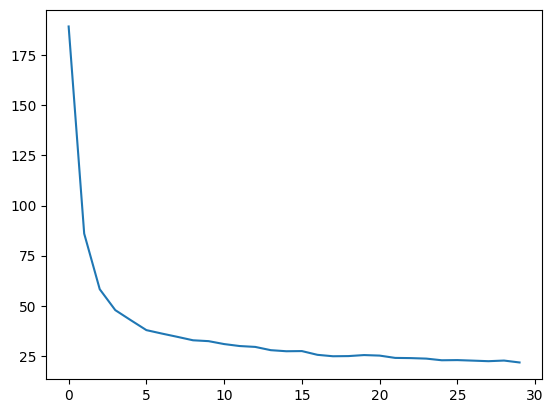

Final loss is 21.674312591552734


In [163]:
import random

# Input set sizes to use during training
input_sizes = [3, 4]

data = []
for n_inputs in input_sizes:
    samples = torch.from_numpy(np.random.random_sample((sample_size//len(input_sizes), 1, n_inputs))).float()
    for i in range(0, samples.shape[0], batch_size):
        data += [samples[i:i+batch_size]]


recorded_loss = torch.zeros(epochs)

#Se entrena la red
for epoch in range(epochs):
    total_loss = 0.0
    random.shuffle(data)
    for samples in data:
        batch_in = samples
        batch_target = batch_in.sum(-1)
        
        optimiser.zero_grad()
        result = model(batch_in)
        loss = loss_function(result, batch_target)
        total_loss += float(loss)
        loss.backward()
        optimiser.step()
    
    recorded_loss[epoch] = total_loss
    # print(f"Epoch {epoch}, loss {total_loss}")

fig, ax = plt.subplots()
ax.plot(recorded_loss)
#ax.set_ylim([0, 1])
plt.show()
print(f"Final loss is {recorded_loss[-1]}")

<h3>Predecimos para nuevas entradas y comprobamos que es equivariante bajo permutaciones </h3>

In [164]:
examples = torch.tensor([
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [-1, 1, -1, 1],
    [1, -1, 1, -1],
    [0, 0, 0, 0],
], dtype=torch.float).reshape(-1, 1, 4)

with torch.no_grad():
    results = model(examples)

results.numpy()

array([[ 2.0182924],
       [ 2.0182924],
       [-0.5896574],
       [-0.5896574],
       [-0.7628466]], dtype=float32)

<h2>Deeps sets para contar objetos en imagenes.</h2>

<h3>Se cargan los datos, son imagenes de personas, caballos, autos, en algunas de ellas hay combinaciones como vemos a continuación: Un hombre y un caballo.</h3>

In [169]:
import torch
from torchvision.datasets import VOCDetection
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
# Se cargan los datos de las imagenes
dataset = VOCDetection(root='./data', year='2012', image_set='train', download=True)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


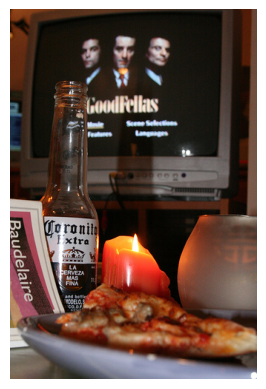

In [170]:
image, target = dataset[3]  # Carga la primera imagen


# Acceder a una imagen y sus anotaciones
image, target = dataset[3]  # Carga la primera imagen

# Mostrar la imagen con matplotlib directamente (sin necesidad de convertirla a tensor)
plt.imshow(image)  # `image` ya es un objeto PIL.Image
plt.axis('off')  # Para ocultar los ejes
plt.show()

<h3>Estas imágenes tienen metadatos de lo que contienen</h3>

In [171]:
dataset[3][1]

{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000023.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '333', 'height': '500', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'tvmonitor',
    'pose': 'Frontal',
    'truncated': '1',
    'occluded': '1',
    'bndbox': {'xmin': '6', 'ymin': '1', 'xmax': '314', 'ymax': '262'},
    'difficult': '0'},
   {'name': 'bottle',
    'pose': 'Unspecified',
    'truncated': '1',
    'occluded': '1',
    'bndbox': {'xmin': '40', 'ymin': '97', 'xmax': '121', 'ymax': '411'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Frontal',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '137', 'ymin': '36', 'xmax': '169', 'ymax': '109'},
    'difficult': '0'},
   {'name': 'person',
    'pose': 'Frontal',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '180', 'ymin': '36', 'xmax': '216', 'ymax': '104'},
    'diffi

<h3>Se crea la estructura</h3>

In [172]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights


# Definir el extractor de características usando ResNet18
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # Usamos una red preentrenada (ResNet18) y extraemos las características antes de la capa final
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Cargar los pesos preentrenados correctamente
        # Remover la última capa completamente conectada (FC)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])  
        
        # Una forma de calcular dinámicamente el número de características:
        self.dummy_input = torch.randn(1, 3, 224, 224)
        self.dummy_output = self.resnet(self.dummy_input)
        self.fc_input_features = self.dummy_output.numel()  # Número total de características de salida
        
        # Capa completamente conectada (FC) para reducir dimensiones
        self.fc = nn.Linear(self.fc_input_features, 256)  # Reducir a 256 características

    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)
        features = features.view(features.size(0), -1)  # Flatten
        return self.fc(features)


# Definir el modelo Deep Sets
class DeepSets(nn.Module):
    def __init__(self, feature_extractor):
        super(DeepSets, self).__init__()
        self.feature_extractor = feature_extractor
        self.fc = nn.Linear(256, 1)  # Para hacer la predicción final (por ejemplo, número de objetos)

    def forward(self, x):
        # x es un conjunto de imágenes (batch)
        batch_size = x.size(0)  # Obtener el tamaño del batch
        
        # Inicializar una lista para almacenar las características de cada imagen en el batch
        features = []

        # Extraemos características para cada imagen en el batch
        for i in range(batch_size):
            feature = self.feature_extractor(x[i:i+1])  # Extraemos la característica para cada imagen
            features.append(feature)

        # Convertimos la lista de características en un tensor
        features = torch.cat(features, dim=0)  # Concatenamos las características del batch

        # Operación simétrica: en lugar de hacer una suma global, procesamos las características individualmente
        # Ahora cada imagen tiene su propio valor de predicción
        output = self.fc(features)  # Salida para cada imagen por separado

        return output


# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Aseguramos que todas las imágenes tengan un tamaño consistente
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Definir una función personalizada de collate para manejar diferentes tamaños de imágenes
def collate_fn(batch):
    images, targets = zip(*batch)
    images = [transform(img) for img in images]  # Aplica la transformación a cada imagen
    images = torch.stack(images, dim=0)  # Stack en un batch
    return images, targets


# Cargar el dataset Pascal VOC
dataset = datasets.VOCDetection(
    root='./data',
    year='2012',
    image_set='train',
    download=True,
    transform=None  # Desactivamos la transformación aquí
)

# Crear un DataLoader para manejar los lotes de datos con collate_fn
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Instanciamos el extractor de características y el modelo Deep Sets
feature_extractor = FeatureExtractor()
model = DeepSets(feature_extractor)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Como estamos prediciendo un valor numérico (número de objetos)

# Entrenamiento
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, target in dataloader:
        optimizer.zero_grad()

        # En lugar de utilizar las etiquetas de clase, contamos el número de objetos (etiquetas 'annotation')
        num_objects = [len(t['annotation']['object']) if 'object' in t['annotation'] else 0 for t in target]
        
        # Hacer una predicción
        outputs = model(images)

        # Convertimos num_objects a tensor flotante
        num_objects = torch.tensor(num_objects, dtype=torch.float32).unsqueeze(1)  # Aseguramos que tenga forma [batch_size, 1]

        # Calcular la pérdida
        loss = criterion(outputs.squeeze(), num_objects.squeeze())  # Squeeze si es necesario para asegurar la forma
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Epoch 1, Loss: 8.163541200598116
Epoch 2, Loss: 8.162811571184319
Epoch 3, Loss: 7.93675795848045
Epoch 4, Loss: 7.951075377289232
Epoch 5, Loss: 7.960972297347926
Epoch 6, Loss: 7.9685973347067


KeyboardInterrupt: 

<h3>Realizar una predicción:</h3>

In [180]:
# Predicción con una imagen de ejemplo
model.eval()
example_image, _ = dataset[2]  # Tomamos la primera imagen del dataset
example_image = transform(example_image).unsqueeze(0)  # Aplicamos la transformación y agregamos una dimensión de batch

# Hacer la predicción
with torch.no_grad():
    output = model(example_image)
    print(f"Predicción de número de objetos: {output.item()}")

Predicción de número de objetos: 3.344844102859497


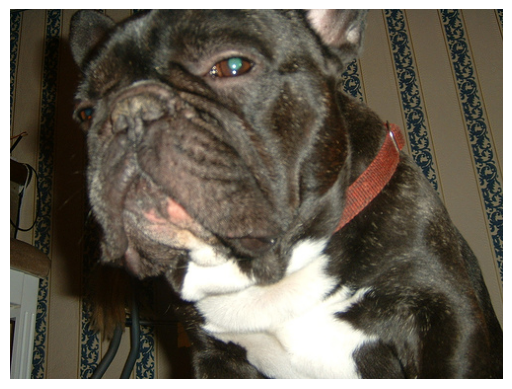

In [181]:


# Acceder a una imagen y sus anotaciones
image, target = dataset[2]  # Carga la primera imagen

# Mostrar la imagen con matplotlib directamente (sin necesidad de convertirla a tensor)
plt.imshow(image)  # `image` ya es un objeto PIL.Image
plt.axis('off')  # Para ocultar los ejes
plt.show()

In [182]:
dataset[10]

(<PIL.Image.Image image mode=RGB size=500x375>,
 {'annotation': {'folder': 'VOC2012',
   'filename': '2008_000053.jpg',
   'source': {'database': 'The VOC2008 Database',
    'annotation': 'PASCAL VOC2008',
    'image': 'flickr'},
   'size': {'width': '500', 'height': '375', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'dog',
     'pose': 'Frontal',
     'truncated': '1',
     'occluded': '0',
     'bndbox': {'xmin': '54', 'ymin': '2', 'xmax': '500', 'ymax': '375'},
     'difficult': '0'}]}})